#**SuperMarket Sales Prediction Using XG Boost**#

##Importing Libraries##

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, LabelEncoder, OneHotEncoder, QuantileTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, f_regression, mutual_info_regression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import warnings
!pip install optuna
!pip install category_encoders

warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00


##Loading Dataset##

In [ ]:
print("Loading dataset...")
df = pd.read_csv('train.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())


Loading dataset...
Dataset shape: (4990, 13)
  Product_Identifier Supermarket_Identifier Product_Supermarket_Identifier  \
0              DRA12            CHUKWUDI010              DRA12_CHUKWUDI010   
1              DRA12            CHUKWUDI013              DRA12_CHUKWUDI013   
2              DRA12            CHUKWUDI017              DRA12_CHUKWUDI017   
3              DRA12            CHUKWUDI018              DRA12_CHUKWUDI018   
4              DRA12            CHUKWUDI035              DRA12_CHUKWUDI035   

   Product_Weight Product_Fat_Content  Product_Shelf_Visibility Product_Type  \
0            11.6             Low Fat                  0.068535  Soft Drinks   
1            11.6             Low Fat                  0.040912  Soft Drinks   
2            11.6             Low Fat                  0.041178  Soft Drinks   
3            11.6             Low Fat                  0.041113  Soft Drinks   
4            11.6       Ultra Low fat                  0.000000  Soft Drinks   

   Pr

##EDA##

In [ ]:
print("\nDataset Information:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

print("\nTarget Variable Statistics:")
target_stats = df['Product_Supermarket_Sales'].describe()
print(target_stats)
print(f"Target skewness: {stats.skew(df['Product_Supermarket_Sales'])}")
print(f"Target kurtosis: {stats.kurtosis(df['Product_Supermarket_Sales'])}")


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Product_Identifier              4990 non-null   object 
 1   Supermarket_Identifier          4990 non-null   object 
 2   Product_Supermarket_Identifier  4990 non-null   object 
 3   Product_Weight                  4188 non-null   float64
 4   Product_Fat_Content             4990 non-null   object 
 5   Product_Shelf_Visibility        4990 non-null   float64
 6   Product_Type                    4990 non-null   object 
 7   Product_Price                   4990 non-null   float64
 8   Supermarket_Opening_Year        4990 non-null   int64  
 9   Supermarket _Size               3540 non-null   object 
 10  Supermarket_Location_Type       4990 non-null   object 
 11  Supermarket_Type                4990 non-null   object 
 12  Product_Supe

##Plots##

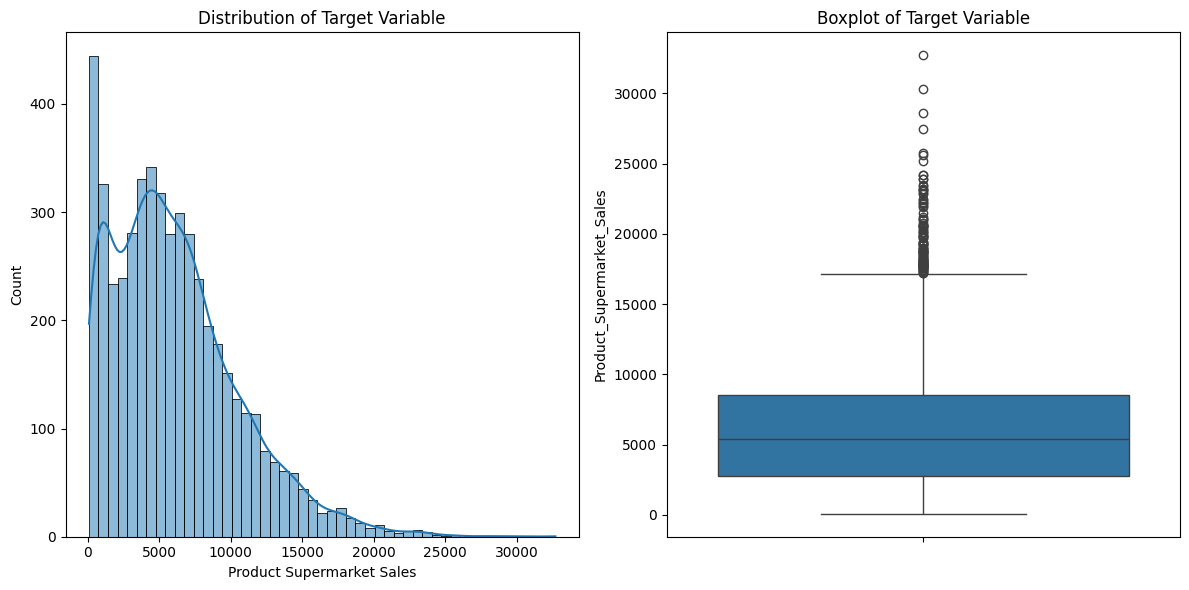

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Product_Supermarket_Sales'], kde=True)
plt.title('Distribution of Target Variable')
plt.xlabel('Product Supermarket Sales')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Product_Supermarket_Sales'])
plt.title('Boxplot of Target Variable')
plt.tight_layout()
plt.show()

##Pearson Correlation##

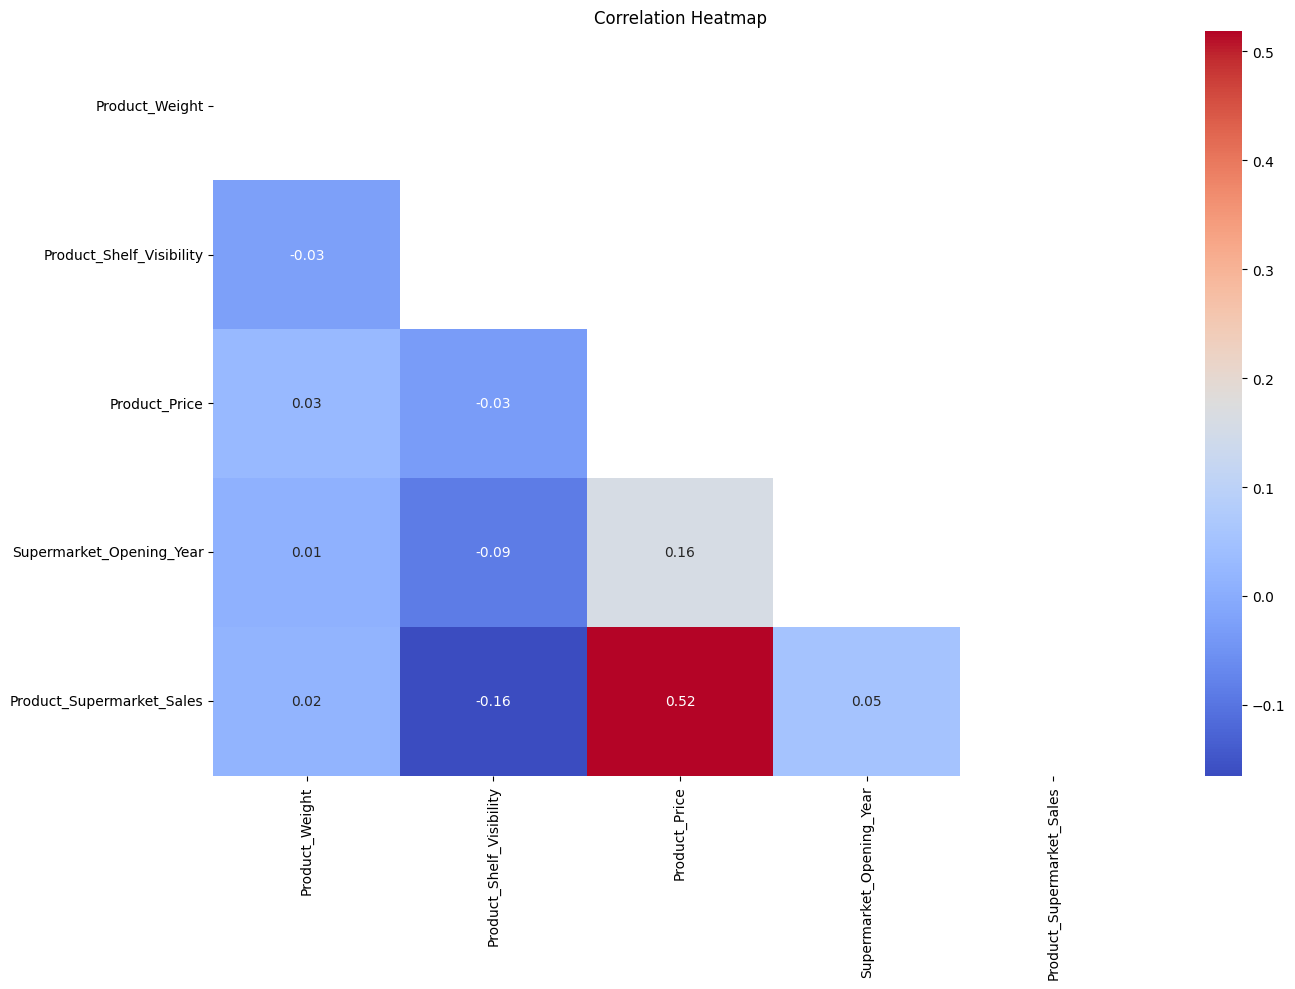

In [ ]:
plt.figure(figsize=(14, 10))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation = df[numeric_cols].corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


##Outlier Detection and Removal##

In [ ]:
def detect_and_handle_outliers(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=['int64', 'float64']).columns
        columns = [col for col in columns if not ('Identifier' in col or col == 'Product_Supermarket_Sales')]

    outlier_stats = {}
    df_cleaned = df.copy()

    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_stats[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

        df_cleaned[col] = df_cleaned[col].clip(lower=lower_bound, upper=upper_bound)

    print("\nOutlier Statistics:")
    for col, stats in outlier_stats.items():
        print(f"{col}: {stats['count']} outliers ({stats['percentage']:.2f}%)")

    return df_cleaned, outlier_stats

df_cleaned, outlier_stats = detect_and_handle_outliers(df)



Outlier Statistics:
Product_Weight: 0 outliers (0.00%)
Product_Shelf_Visibility: 98 outliers (1.96%)
Product_Price: 0 outliers (0.00%)
Supermarket_Opening_Year: 0 outliers (0.00%)


##Data Preprocessing##

In [ ]:
def enhanced_preprocessing(df):
    data = df.copy()
    data.columns = [col.strip() for col in data.columns]
    data['Product_Weight'] = data['Product_Weight'].fillna(data['Product_Weight'].median())

    if 'Supermarket _Size' in data.columns:
        data.rename(columns={'Supermarket _Size': 'Supermarket_Size'}, inplace=True)

    data['Supermarket_Size_Missing'] = data['Supermarket_Size'].isna().astype(int)
    data['Supermarket_Size'] = data['Supermarket_Size'].fillna(data['Supermarket_Size'].mode()[0])

    data['Product_Fat_Content'] = data['Product_Fat_Content'].str.lower().str.strip()
    data['Product_Fat_Content'] = data['Product_Fat_Content'].replace({
        'low fat': 'Low Fat', 'lf': 'Low Fat', 'regular': 'Regular', 'reg': 'Regular'
    })

    for col in ['Product_Fat_Content', 'Product_Type', 'Supermarket_Location_Type', 'Supermarket_Type']:
        if col in data.columns:
            value_counts = data[col].value_counts()
            rare_categories = value_counts[value_counts < max(30, len(data) * 0.01)].index.tolist()
            data[col] = data[col].apply(lambda x: 'Other' if x in rare_categories else x)

    return data

df_preprocessed = enhanced_preprocessing(df_cleaned)

##Advanced Feature Engineering##

In [27]:
def advanced_feature_engineering(df):
    data = df.copy()
    numeric_features = ['Product_Weight', 'Product_Shelf_Visibility', 'Product_Price', 'Supermarket_Opening_Year']

    for col in numeric_features:
        if col in data.columns:
            if data[col].min() > 0:
                data[f'log_{col}'] = np.log1p(data[col])
            if data[col].min() >= 0:
                data[f'sqrt_{col}'] = np.sqrt(data[col])
            data[f'{col}_squared'] = data[col] ** 2
            data[f'{col}_cubed'] = data[col] ** 3

    # Safe binning
    if 'Product_Price' in data.columns:
        if data['Product_Price'].nunique() > 1:
            data['price_bin'] = pd.qcut(data['Product_Price'], 10, labels=False, duplicates='drop')
        else:
            data['price_bin'] = 0

    if 'Product_Weight' in data.columns:
        if data['Product_Weight'].nunique() > 1:
            data['weight_bin'] = pd.qcut(data['Product_Weight'], 10, labels=False, duplicates='drop')
        else:
            data['weight_bin'] = 0

    if 'Product_Shelf_Visibility' in data.columns:
        if data['Product_Shelf_Visibility'].nunique() > 1:
            data['visibility_bin'] = pd.qcut(data['Product_Shelf_Visibility'].clip(lower=0.001), 10, labels=False, duplicates='drop')
        else:
            data['visibility_bin'] = 0

    # Visibility-based flags
    data['is_visibility_zero'] = (data['Product_Shelf_Visibility'] == 0).astype(int)
    data['is_visibility_low'] = (data['Product_Shelf_Visibility'] < 0.05).astype(int)
    data['is_visibility_high'] = (data['Product_Shelf_Visibility'] > 0.1).astype(int)

    # Supermarket age features
    current_year = 2025
    data['supermarket_age'] = current_year - data['Supermarket_Opening_Year']
    data['supermarket_age_squared'] = data['supermarket_age'] ** 2
    data['is_new_supermarket'] = (data['supermarket_age'] <= 5).astype(int)
    data['is_old_supermarket'] = (data['supermarket_age'] >= 20).astype(int)

    # Interaction and ratio features
    data['price_per_weight'] = data['Product_Price'] / (data['Product_Weight'] + 0.001)
    data['price_visibility'] = data['Product_Price'] * data['Product_Shelf_Visibility']
    data['weight_visibility'] = data['Product_Weight'] * data['Product_Shelf_Visibility']
    data['price_weight_ratio'] = data['Product_Price'] / (data['Product_Weight'] + 0.001)
    data['price_weight_visibility'] = data['Product_Price'] * data['Product_Weight'] * data['Product_Shelf_Visibility']

    data['log_price_per_weight'] = np.log1p(data['price_per_weight'])
    data['log_price_visibility'] = np.log1p(data['Product_Price'] * (data['Product_Shelf_Visibility'] + 0.001))

    # Label Encoding
    label_encoded_cols = ['Product_Fat_Content', 'Product_Type', 'Supermarket_Location_Type', 'Supermarket_Type']
    for col in label_encoded_cols:
        if col in data.columns:
            le = LabelEncoder()
            data[f'{col}_encoded'] = le.fit_transform(data[col])

    # Categorical * Numerical interaction features
    for cat_col in [f'{col}_encoded' for col in label_encoded_cols if f'{col}_encoded' in data.columns]:
        for num_col in ['Product_Price', 'Product_Shelf_Visibility', 'Product_Weight', 'supermarket_age']:
            if num_col in data.columns:
                data[f'{cat_col}_{num_col}'] = data[cat_col] * data[num_col]

    # Advanced transformations
    data['price_exp'] = np.exp(data['Product_Price'] / data['Product_Price'].max())
    data['visibility_sigmoid'] = 1 / (1 + np.exp(-10 * (data['Product_Shelf_Visibility'] - 0.05)))
    data['price_sin'] = np.sin(data['Product_Price'] / 100)
    data['price_cos'] = np.cos(data['Product_Price'] / 100)

    data['price_to_visibility_ratio'] = data['Product_Price'] / (data['Product_Shelf_Visibility'] + 0.001)
    data['weight_to_visibility_ratio'] = data['Product_Weight'] / (data['Product_Shelf_Visibility'] + 0.001)

    data['price_visibility_squared'] = data['Product_Price'] * (data['Product_Shelf_Visibility'] ** 2)
    data['price_squared_visibility'] = (data['Product_Price'] ** 2) * data['Product_Shelf_Visibility']

    return data
df_engineered = advanced_feature_engineering(df_preprocessed)

##Visual Comparison of Target Variable Transformations and Skewness##

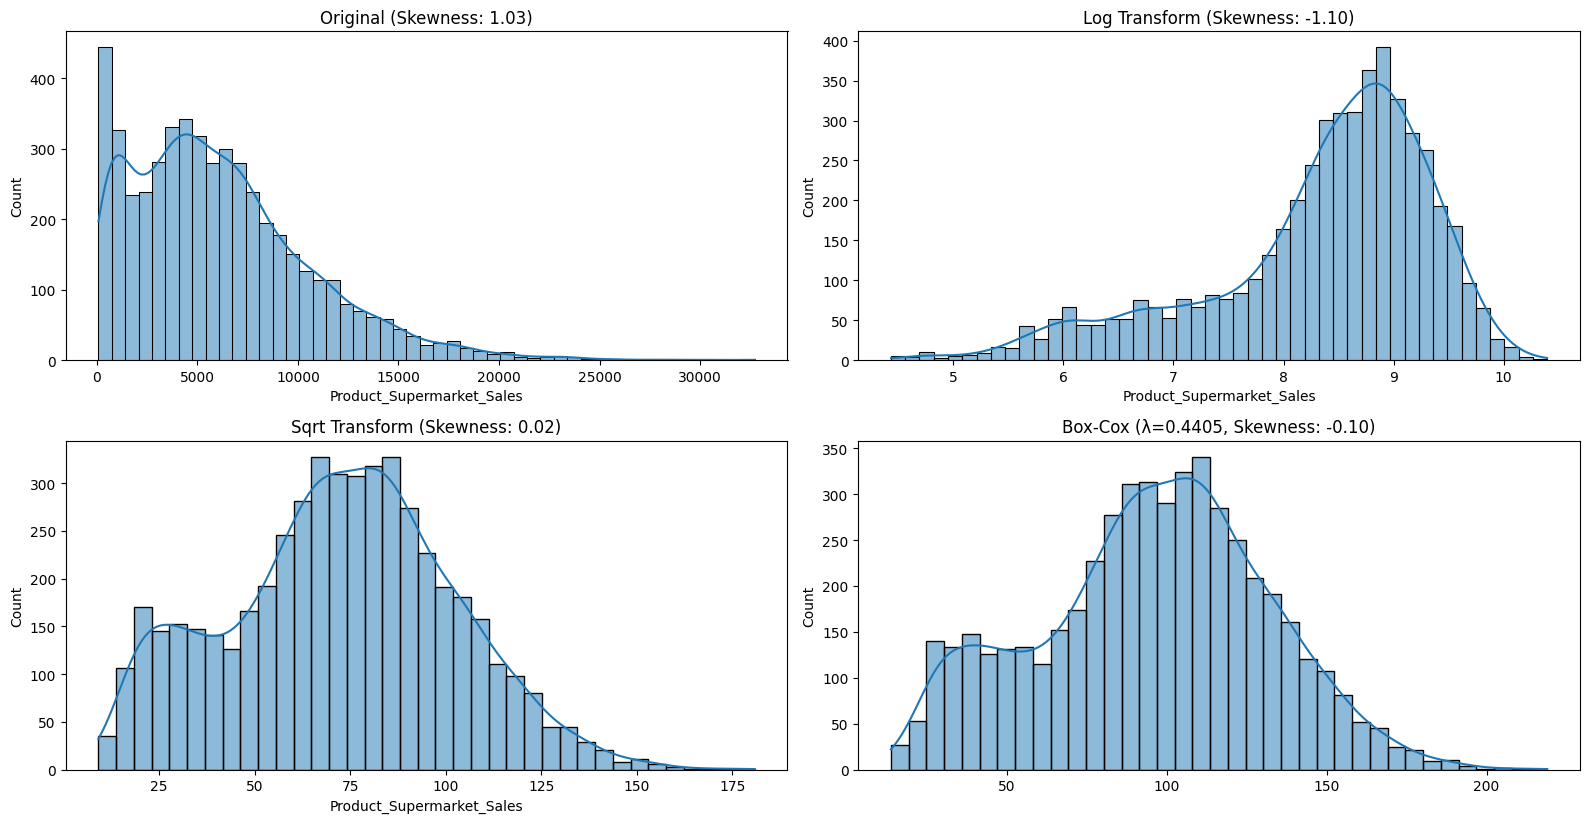

In [ ]:
plt.figure(figsize=(16, 12))

y = df_engineered['Product_Supermarket_Sales']

# Original distribution
plt.subplot(3, 2, 1)
sns.histplot(y, kde=True)
plt.title(f'Original (Skewness: {stats.skew(y):.2f})')

# Log transformation
if y.min() > 0:
    y_log = np.log1p(y)
    plt.subplot(3, 2, 2)
    sns.histplot(y_log, kde=True)
    plt.title(f'Log Transform (Skewness: {stats.skew(y_log):.2f})')
else:
    y_log = None

# Square root transformation
if y.min() >= 0:
    y_sqrt = np.sqrt(y)
    plt.subplot(3, 2, 3)
    sns.histplot(y_sqrt, kde=True)
    plt.title(f'Sqrt Transform (Skewness: {stats.skew(y_sqrt):.2f})')
else:
    y_sqrt = None

# Box-Cox transformation
if y.min() > 0:
    y_boxcox, lambda_boxcox = stats.boxcox(y)
    plt.subplot(3, 2, 4)
    sns.histplot(y_boxcox, kde=True)
    plt.title(f'Box-Cox (λ={lambda_boxcox:.4f}, Skewness: {stats.skew(y_boxcox):.2f})')
else:
    y_boxcox, lambda_boxcox = None, None

plt.tight_layout()
plt.show()

##Target Variable Transformation and Skewness Minimization##

In [ ]:
def explore_target_transformations(y):

    transformations = {
        'original': (y, None, None, stats.skew(y)),
        'log': (np.log1p(y) if y.min() > 0 else None, np.log1p, np.expm1, stats.skew(np.log1p(y)) if y.min() > 0 else np.inf),
        'sqrt': (np.sqrt(y) if y.min() >= 0 else None, np.sqrt, lambda x: x**2, stats.skew(np.sqrt(y)) if y.min() >= 0 else np.inf),
        'boxcox': (stats.boxcox(y)[0] if y.min() > 0 else None, lambda x: stats.boxcox(x, lmbda=stats.boxcox(y)[1]), lambda x: stats.inv_boxcox(x, stats.boxcox(y)[1]), stats.skew(stats.boxcox(y)[0]) if y.min() > 0 else np.inf)
    }

    # Yeo-Johnson transformation
    pt = PowerTransformer(method='yeo-johnson')
    y_yeojohnson = pt.fit_transform(y.values.reshape(-1, 1)).flatten()
    transformations['yeojohnson'] = (y_yeojohnson, lambda x: pt.transform(x.reshape(-1, 1)).flatten(), lambda x: pt.inverse_transform(x.reshape(-1, 1)).flatten(), stats.skew(y_yeojohnson))

    # Quantile transformation
    from sklearn.preprocessing import QuantileTransformer
    qt = QuantileTransformer(output_distribution='normal')
    y_quantile = qt.fit_transform(y.values.reshape(-1, 1)).flatten()
    transformations['quantile'] = (y_quantile, lambda x: qt.transform(x.reshape(-1, 1)).flatten(), lambda x: qt.inverse_transform(x.reshape(-1, 1)).flatten(), stats.skew(y_quantile))

    # Find the transformation with the lowest skewness
    best_transform = min(transformations, key=lambda k: transformations[k][3])


    return transformations, best_transform

##Data Preprocessing and Feature Selection with Transformation and Encoding##

In [ ]:
from category_encoders import TargetEncoder

# Prepare data for feature selection
target_column = 'Product_Supermarket_Sales'
id_columns = ['Product_Identifier', 'Supermarket_Identifier', 'Product_Supermarket_Identifier']

transformations, best_transform_name = explore_target_transformations(df_engineered[target_column])

transform_data, transform_func, inverse_func, skewness = transformations[best_transform_name]

transformed_target_column = f'{target_column}_transformed'
df_engineered[transformed_target_column] = transform_func(df_engineered[target_column])

# Feature Selection
X = df_engineered.drop(id_columns + [target_column, transformed_target_column], axis=1)
y = df_engineered[transformed_target_column]

categorical_cols = ['Product_Fat_Content', 'Product_Type', 'Supermarket_Location_Type', 'Supermarket_Type']
categorical_cols = [col for col in categorical_cols if col in X.columns]

for col in categorical_cols:
    if col in X.columns:
        encoder = TargetEncoder()
        X[f'{col}_target_encoded'] = encoder.fit_transform(X[col], y)

for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Method 1: Correlation (linear relationships only)
correlations = list(zip(X.columns, X.corrwith(y).abs()))
correlations.sort(key=lambda x: x[1], reverse=True)

# Method 2: Mutual Information (captures non-linear relationships)
mi_selector = SelectKBest(mutual_info_regression, k='all')
mi_selector.fit(X, y)
mi_scores = list(zip(X.columns, mi_selector.scores_))
mi_scores.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 features by mutual information:")
for col, score in mi_scores[:10]:
    print(f"{col}: {score:.4f}")

# Method 3: XGBoost built-in feature importance
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X, y)

xgb_importance = list(zip(X.columns, xgb_model.feature_importances_))
xgb_importance.sort(key=lambda x: x[1], reverse=True)

print("\nTop 10 features by XGBoost importance:")
for col, importance in xgb_importance[:10]:
    print(f"{col}: {importance:.4f}")

# Combine rankings from all 3 methods
all_features = {}
for i, (col, _) in enumerate(correlations):
    all_features[col] = all_features.get(col, 0) + (len(correlations) - i)

for i, (col, _) in enumerate(mi_scores):
    all_features[col] = all_features.get(col, 0) + (len(mi_scores) - i)

for i, (col, _) in enumerate(xgb_importance):
    all_features[col] = all_features.get(col, 0) + (len(xgb_importance) - i)

combined_scores = [(col, score) for col, score in all_features.items()]
combined_scores.sort(key=lambda x: x[1], reverse=True)



Top 10 features by mutual information:
Supermarket_Type_encoded_Product_Price: 0.8178
log_Product_Price: 0.8031
sqrt_Product_Price: 0.7643
Product_Price: 0.7433
price_exp: 0.7377
Product_Price_squared: 0.7307
Product_Price_cubed: 0.7285
price_sin: 0.5774
price_bin: 0.5285
price_cos: 0.5103

Top 10 features by XGBoost importance:
Supermarket_Type_encoded_Product_Price: 0.7220
Supermarket_Opening_Year: 0.0455
Product_Price: 0.0444
price_cos: 0.0128
price_sin: 0.0085
Supermarket_Location_Type_encoded_supermarket_age: 0.0077
price_weight_visibility: 0.0063
Supermarket_Location_Type_encoded_Product_Price: 0.0061
Supermarket_Type_target_encoded: 0.0061
log_price_visibility: 0.0060


##Finding optimal feature count using Cross-Validation##

In [ ]:
best_score = -np.inf
best_feature_count = 20

print("\nFinding optimal feature count...")
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for n_features in range(20, min(50, len(combined_scores)) + 1, 5):
    selected_features = [col for col, _ in combined_scores[:n_features]]
    X_selected = X[selected_features]

    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    cv_scores = cross_val_score(model, X_selected, y, cv=cv, scoring='r2')
    avg_score = np.mean(cv_scores)

    print(f"Features: {n_features}, Avg R²: {avg_score:.4f}")

    if avg_score > best_score:
        best_score = avg_score
        best_feature_count = n_features

best_features = [col for col, _ in combined_scores[:best_feature_count]]
print(f"\nSelected {len(best_features)} features with avg R²: {best_score:.4f}")


Finding optimal feature count...
Features: 20, Avg R²: 0.7143
Features: 25, Avg R²: 0.7179
Features: 30, Avg R²: 0.7155
Features: 35, Avg R²: 0.7155
Features: 40, Avg R²: 0.7144
Features: 45, Avg R²: 0.7118
Features: 50, Avg R²: 0.7120

Selected 25 features with avg R²: 0.7179


##Feature Selection, Data Splitting, Scaling & XGBoost Hyperparameter Optimization##

In [ ]:
print("\nSelected Features:")
for feature in best_features:
    print(f"- {feature}")

# Split data into train, validation, and test sets
X_selected = X[best_features]
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nTrain: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Function to optimize XGBoost hyperparameters using Optuna
def optimize_xgboost_hyperparameters(X_train, y_train, X_val, y_val, n_trials=100):
    print("\nOptimizing XGBoost hyperparameters with Optuna...")

    def objective(trial):
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0.0, 0.5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
            'random_state': 42
        }

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(param, dtrain,
                          evals=[(dval, 'eval')],
                          early_stopping_rounds=50,
                          verbose_eval=False)


        y_pred = model.predict(dval)
        r2 = r2_score(y_val, y_pred)
        return r2



Selected Features:
- Product_Price
- Supermarket_Type_target_encoded
- Supermarket_Type_encoded_Product_Price
- Supermarket_Opening_Year
- price_bin
- price_sin
- log_Product_Price
- Supermarket_Type
- sqrt_Product_Price
- Supermarket_Type_encoded_Product_Weight
- price_cos
- Supermarket_Location_Type_encoded_Product_Price
- Product_Price_squared
- Product_Price_cubed
- Supermarket_Type_encoded_supermarket_age
- price_per_weight
- Supermarket_Opening_Year_squared
- Supermarket_Opening_Year_cubed
- log_Supermarket_Opening_Year
- Product_Shelf_Visibility
- sqrt_Supermarket_Opening_Year
- supermarket_age
- Supermarket_Type_encoded_Product_Shelf_Visibility
- Supermarket_Location_Type_encoded_supermarket_age
- Product_Type_encoded_Product_Price

Train: 3493 samples
Validation: 748 samples
Test: 749 samples


##Optuna-Based XGBoost Hyperparameter Tuning and Final Model Training##

In [ ]:
import optuna

def optimize_xgboost_hyperparameters(X_train, y_train, X_val, y_val, n_trials=100):
    def objective(trial):
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0.0, 0.5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
            'random_state': 42
        }

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(param, dtrain,
                          evals=[(dval, 'eval')],
                          early_stopping_rounds=50,
                          verbose_eval=False)

        y_pred = model.predict(dval)
        return r2_score(y_val, y_pred)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print(f"\nBest validation R²: {study.best_value:.4f}")
    print("\nBest hyperparameters:")
    for param, value in study.best_params.items():
        print(f"- {param}: {value}")

    return study.best_params

# Optimizing XGBoost hyperparameters
best_params = optimize_xgboost_hyperparameters(X_train_scaled, y_train, X_val_scaled, y_val, n_trials=50)

dtrain_val = xgb.DMatrix(np.vstack((X_train_scaled, X_val_scaled)), label=np.concatenate((y_train, y_val)))
final_model = xgb.train(best_params, dtrain_val)


[I 2025-05-05 20:15:12,433] A new study created in memory with name: no-name-cc7074aa-2c19-4af3-bc88-5e1043a1e45d
[I 2025-05-05 20:15:12,476] Trial 0 finished with value: 0.08710311540244564 and parameters: {'n_estimators': 254, 'max_depth': 5, 'learning_rate': 0.006779710267320753, 'subsample': 0.7619222031071164, 'colsample_bytree': 0.8043776073409253, 'min_child_weight': 7, 'gamma': 0.31130089315569826, 'reg_alpha': 0.06114965648275472, 'reg_lambda': 3.5333002777654032}. Best is trial 0 with value: 0.08710311540244564.
[I 2025-05-05 20:15:12,508] Trial 1 finished with value: 0.4294359261236135 and parameters: {'n_estimators': 891, 'max_depth': 3, 'learning_rate': 0.04747134048269006, 'subsample': 0.6988536241785019, 'colsample_bytree': 0.9703591516627097, 'min_child_weight': 10, 'gamma': 0.14673208581104957, 'reg_alpha': 0.754854857525533, 'reg_lambda': 4.613071960953479}. Best is trial 1 with value: 0.4294359261236135.
[I 2025-05-05 20:15:12,566] Trial 2 finished with value: 0.4944


Best validation R²: 0.7331

Best hyperparameters:
- n_estimators: 539
- max_depth: 4
- learning_rate: 0.29813924263132785
- subsample: 0.8409379389411435
- colsample_bytree: 0.6407631527655758
- min_child_weight: 9
- gamma: 0.13940726486139754
- reg_alpha: 0.7376205607213125
- reg_lambda: 0.927182566882301


##Model Evaluation on Train and Test Sets Using Regression Metrics##

In [ ]:
# Evaluate on train and test sets
dtrain = xgb.DMatrix(X_train_scaled)
dtest = xgb.DMatrix(X_test_scaled)

y_train_pred = final_model.predict(dtrain)
y_test_pred = final_model.predict(dtest)

# Train set metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
sd_train = np.std(np.abs(y_train - y_train_pred))

# Test set metrics
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)
sd_test = np.std(np.abs(y_test - y_test_pred))

print(f"\nTrain Set Metrics:")
print(f"R²: {r2_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"Standard Deviation of Errors: {sd_train:.4f}")

print(f"\nTest Set Metrics:")
print(f"R²: {r2_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"Standard Deviation of Errors: {sd_test:.4f}")



Train Set Metrics:
R²: 0.7578
MAE: 0.3982
MSE: 0.2609
RMSE: 0.5107
Standard Deviation of Errors: 0.3199

Test Set Metrics:
R²: 0.7342
MAE: 0.4115
MSE: 0.2624
RMSE: 0.5122
Standard Deviation of Errors: 0.3050


##Visualization: Actual vs Predicted and Error Distribution on Test Set##

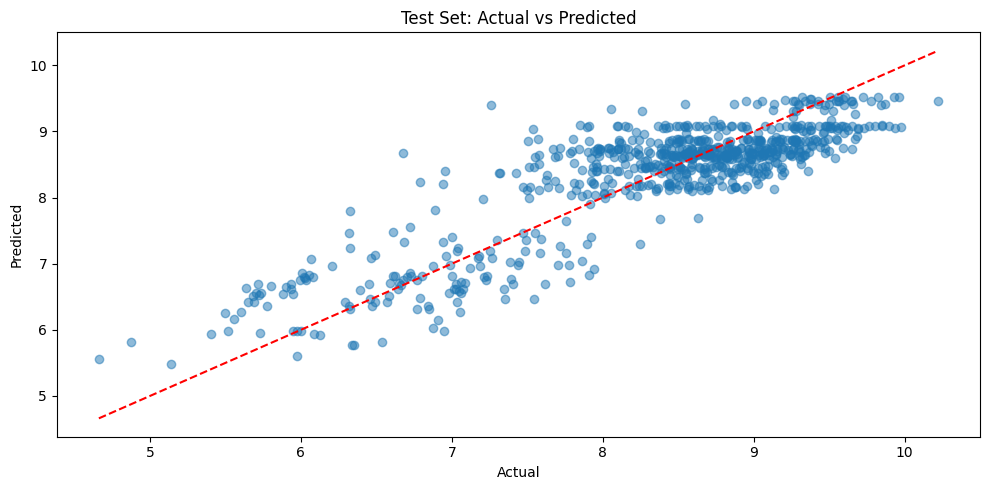

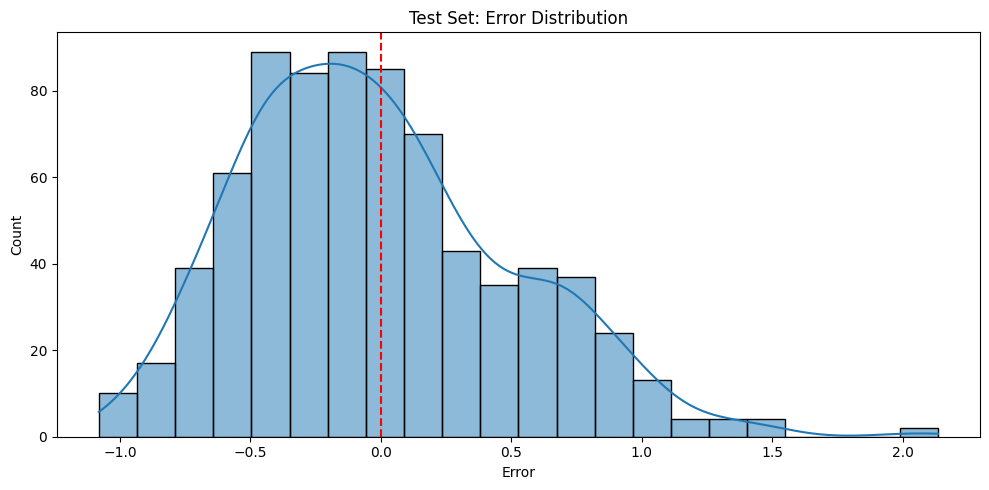

In [21]:
# Actual vs Predicted (Test)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Test Set: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.tight_layout()
plt.show()

# Error Distribution (Test)
plt.figure(figsize=(10, 5))
sns.histplot(y_test_pred - y_test, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title("Test Set: Error Distribution")
plt.xlabel("Error")
plt.tight_layout()
plt.show()

#Test Case 1#

In [29]:
#Input
product_weight = 11.25
product_fat_content = 'Low Fat'
product_visibility = 0.9
product_type = 'Sodt Drink'
product_price = 57.99
supermarket_size = 'Medium'
location_type = 'Urban'
supermarket_type = 'Grocery Store'
opening_year = 1994

input_values = {
    'Product_Weight': product_weight,
    'Product_Fat_Content': product_fat_content,
    'Product_Shelf_Visibility': product_visibility,
    'Product_Type': product_type,
    'Product_Price': product_price,
    'Supermarket_Size': supermarket_size,
    'Supermarket_Location_Type': location_type,
    'Supermarket_Type': supermarket_type,
    'Supermarket_Opening_Year': opening_year
}

sample_df = pd.DataFrame([input_values])

sample_df = enhanced_preprocessing(sample_df)

sample_df_engineered = advanced_feature_engineering(sample_df)

if not isinstance(sample_df_engineered, pd.DataFrame):
    print("Error: Feature engineering did not return a DataFrame.")
    sample_df_engineered = sample_df.copy()

missing_features = [f for f in best_features if f not in sample_df_engineered.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")
    for feature in missing_features:
        sample_df_engineered[feature] = 0

available_features = [f for f in best_features if f in sample_df_engineered.columns]
input_data = sample_df_engineered[available_features]

from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['Product_Fat_Content', 'Product_Type', 'Supermarket_Location_Type', 'Supermarket_Type']
for col in categorical_cols:
    if col in input_data.columns:
        encoder = TargetEncoder()
        input_data[f'{col}_target_encoded'] = encoder.fit(X[col], y).transform(input_data[col])

for col in input_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    try:
        input_data[col] = le.fit(X[col]).transform(input_data[col])
    except:
        input_data[col] = 0

input_scaled = scaler.transform(input_data)

dpredict = xgb.DMatrix(input_scaled)
prediction_transformed = final_model.predict(dpredict)[0]

prediction = inverse_func(prediction_transformed)

insights = []
if product_visibility == 0:
    insights.append("Product has zero visibility which typically results in lower sales.")
elif product_visibility < 0.05:
    insights.append("Product has low visibility which may limit sales potential.")

if product_price > 400:
    insights.append("Product price is relatively high, which may affect sales volume.")

current_year = 2023
years_operating = current_year - opening_year
if years_operating < 5:
    insights.append("The supermarket is relatively new, which might impact customer loyalty and sales.")

print(f"\nPredicted Product Supermarket Sales: {prediction:.2f}")
print("\nPrediction Insights:")
for insight in insights:
    print(f"- {insight}")

print(f"\nInput Values Used:")
for key, value in input_values.items():
    print(f"- {key}: {value}")



Predicted Product Supermarket Sales: 711.04

Prediction Insights:

Input Values Used:
- Product_Weight: 11.25
- Product_Fat_Content: Low Fat
- Product_Shelf_Visibility: 0.9
- Product_Type: Sodt Drink
- Product_Price: 57.99
- Supermarket_Size: Medium
- Supermarket_Location_Type: Urban
- Supermarket_Type: Grocery Store
- Supermarket_Opening_Year: 1994
